In [105]:
#!/usr/bin/env python3

"""
A example for GFO. This example uses a diabetes dataset found on kaggle.
Below is an example of how to use GFO to identify valuable features, reduce
dimentionality, and interpret results.
"""
from learner import GFO
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

# Load the raw data
raw_data = pd.read_csv('diabetes.csv')

# Develop our feature set matrix. We are given the features,
# Pregnancies
# Glucose
# Blood Pressure
# Skin Thickness
# Insulin
# BMI
# DiabetesPedigreeFunction
# Age

A = np.matrix(raw_data.loc[:, 'Pregnancies': 'Age'])

# The vector that contains our answer is the outcome vector.
b = np.matrix(raw_data['Outcome']).T

# Use GFO to attempt to learn about how the features in A determine
# the value of the answers in b.
x, r, steps = GFO(A, b).learn(lrs=2)

accuracy = 1 - (np.count_nonzero(np.rint(A*steps[-1]) - b) / len(b))
print('accuracy = ', accuracy)
print(steps[-1])
print(np.around(steps[-1], decimals=3))

global_epoch= 3 local plane= 0 res= 14.504036912941066
global_epoch= 17 local plane= 0 res= 12.197184859406093
accuracy =  0.7057291666666667
[[ 0.02226503]
 [ 0.00050528]
 [-0.00291815]
 [-0.00039719]
 [-0.00016963]
 [ 0.01079107]
 [ 0.15975332]
 [ 0.00052165]]
[[ 0.022]
 [ 0.001]
 [-0.003]
 [-0.   ]
 [-0.   ]
 [ 0.011]
 [ 0.16 ]
 [ 0.001]]


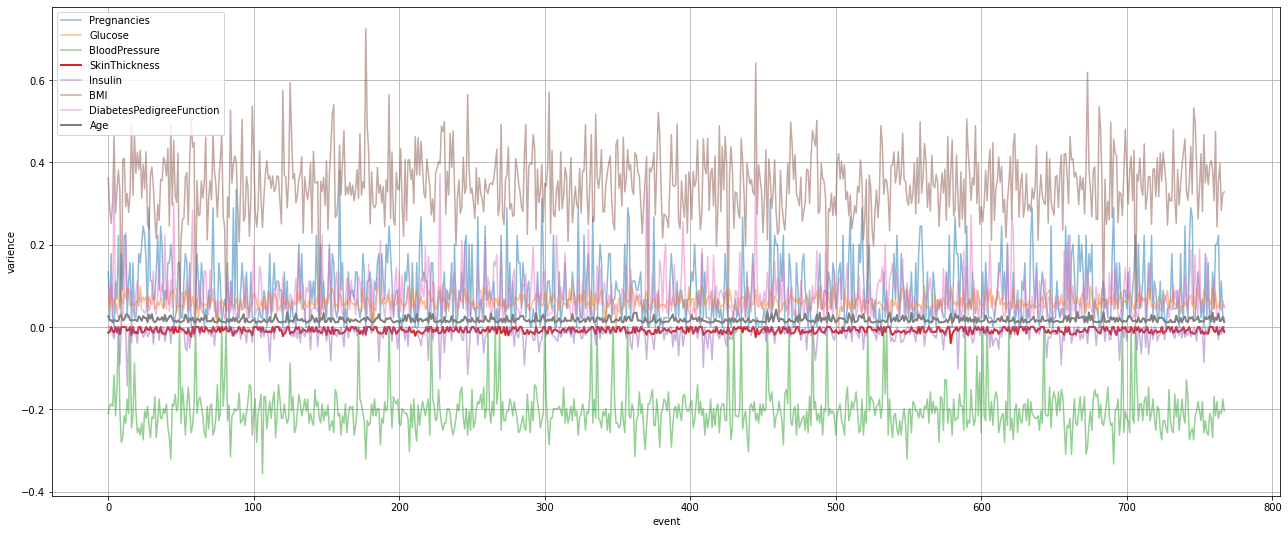

In [106]:
"""
Lets look at the answer

w = [[ 0.024]  - Pregnancies
     [ 0.001]  - Glucose
     [-0.003]  - Blood Pressure
     [-0.   ]  - Skin Thickness
     [-0.   ]  - Insulin
     [ 0.01 ]  - BMI
     [ 0.162]  - DiabetesPedigreeFunction
     [ 0.001]] - Age
     
Some of these values are 0 or close to 0. Is this a coincidence? Or is there something special.
We can look at the contributions of each feature by looking at the var of each feature and
the variance of combination of features. From there we can find features that do not bring
significant information, remove them, and repeat the GFO learning process. Doing this as many
times as the user sees necessary. Features that provide < 1% of varience are culled, there are
better way to determine what features to cull, but this notebook aims to educate not confuse.
"""

total_var = 0
for i in range(A.shape[1]):
    total_var += np.var(A[:, i]*x[i])

plt.figure(figsize=(22, 9))


next_data = raw_data.copy()

for i in range(A.shape[1]):
    if np.var(A[:, i]*x[i]) / total_var < 0.01:
        plt.plot(A[:, i]*x[i], label=raw_data.columns[i], linestyle='-', linewidth=2.0)
        next_data.pop(raw_data.columns[i])
    else:
        plt.plot(A[:, i]*x[i], label=raw_data.columns[i], alpha=0.5)
        
plt.ylabel('varience')
plt.xlabel('event')
plt.grid()
plt.legend()
plt.show()

In [107]:
"""
Rerun the learner removing components that provide <1% of the variance of the final
series.
"""

# Reconstruct A and b
A = np.matrix(next_data.iloc[:,:-1])
b = np.matrix(raw_data['Outcome']).T

# Now that features are culled we can increase the learning iterations
# to obtain a more precise answer. If we removed noise, we should see
# an increase in accuracy in the model.
x, r, steps = GFO(A, b).learn(lrs=3)

accuracy = 1 - (np.count_nonzero(np.rint(A*steps[-1]) - b) / len(b))
print('accuracy = ', accuracy)
print(np.around(steps[-1], decimals=3))

global_epoch= 3 local plane= 0 res= 13.967113877047736
global_epoch= 10 local plane= 0 res= 12.186685787380464
global_epoch= 27 local plane= 0 res= 11.737000399619685
accuracy =  0.75
[[ 0.023]
 [ 0.003]
 [-0.005]
 [ 0.   ]
 [ 0.005]
 [ 0.092]]


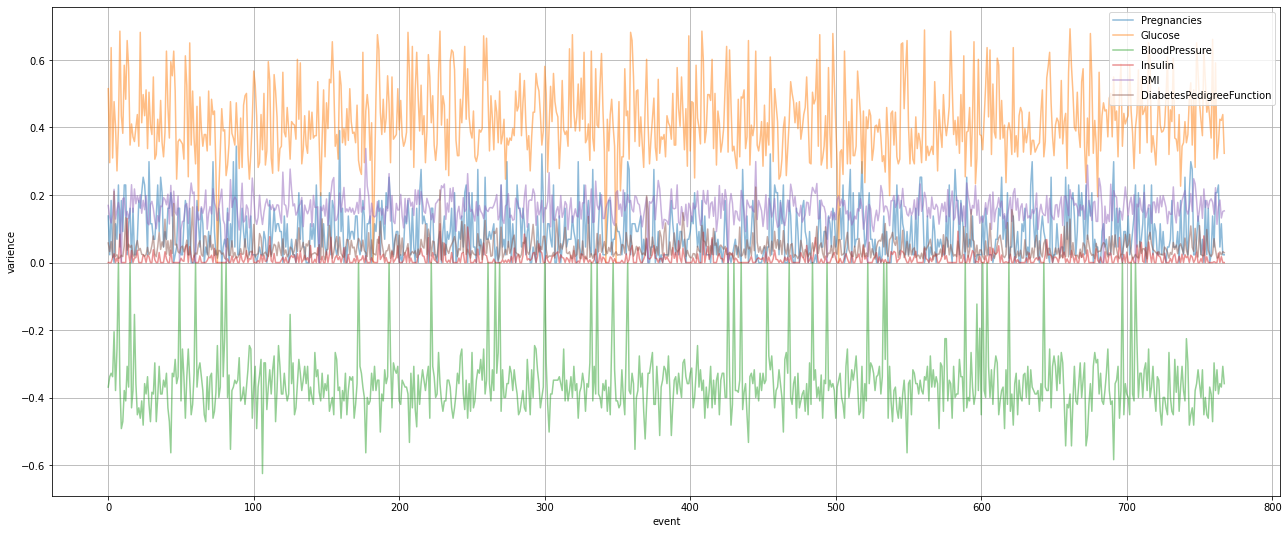

In [108]:
"""
Culling the noisy features provided little value allowed us to reduced dimentionality
and allowed us to run a more precise analysis. In the process accuracy improved by 5%.
Running this again to check for insignificant variances.
"""

plt.figure(figsize=(22, 9))
for i in range(A.shape[1]):
    if np.var(A[:, i]*x[i]) / total_var < 0.01:
        plt.plot(A[:, i]*x[i], label=next_data.columns[i], linestyle='-', linewidth=2.0)
    else:
        plt.plot(A[:, i]*x[i], label=next_data.columns[i], alpha=0.5)

plt.ylabel('varience')
plt.xlabel('event')
plt.legend(loc=1)
plt.grid()
plt.show()

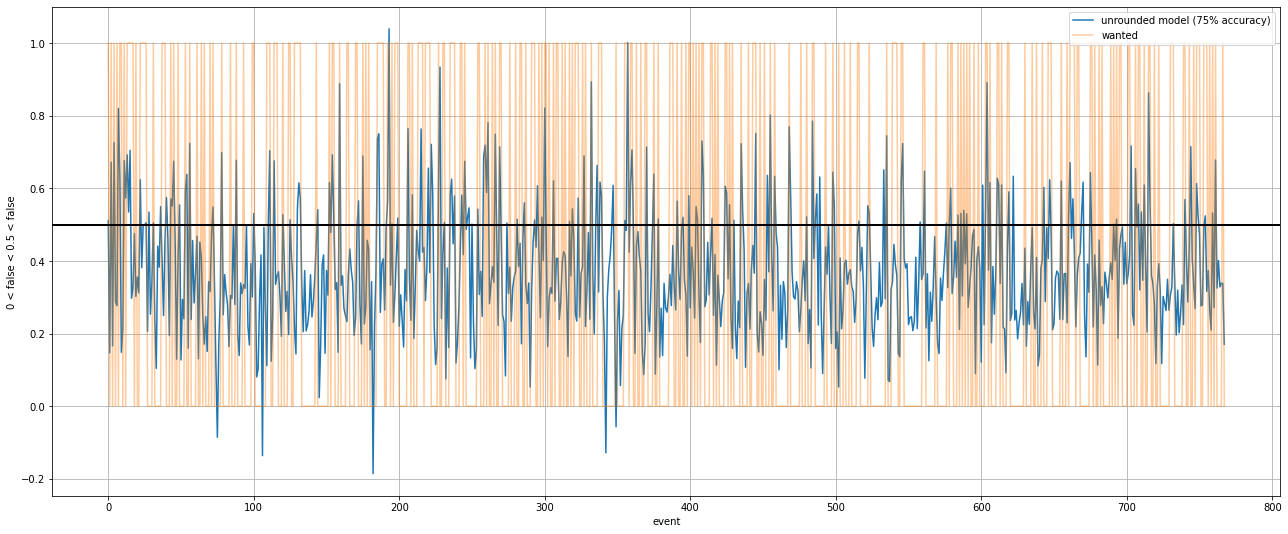

In [129]:
"""
Since there are no more variences that contribute <1%, we conclude. We have shown in this
simple example that SkinThickness and Age have little contribution to the fact a person has
diabetes. And that that the model defined by
round(0.02298123*Pregnancies + 0.0034791*Glucose - 0.00512329*BloodPressure + 0.00015471*Insulin + 0.00503466*BMI + 0.09235591*DiabetesPedigreeFunction)
is an OK first pass approximation to fitting the features to the data.
"""
plt.figure(figsize=(22, 9))
plt.plot(A*x, label='unrounded model (75% accuracy)')
plt.plot(np.rint(b), alpha=0.4, label='wanted')
plt.axhline(0.5, color='black', linewidth=2)
plt.legend(loc=1)
plt.grid()
plt.xlabel('event')
plt.ylabel('0 < false < 0.5 < false')
plt.show()